In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

In [11]:
df = pd.read_excel('champagne-sales.xlsx')
df.head(3)

,Month,Champagne Sales
0,1-01,2851
1,1-02,2672
2,1-03,2755


In [12]:
df['period'] = df.Month.apply(lambda x: x.split('-')[0])
df['month'] = df.Month.apply(lambda x: x.split('-')[1]).astype(str)
df['year'] = (df.period.astype(int) + 2000).astype(str)
df['date'] = df.year + '-' + df.month
df.date = pd.to_datetime(df.date)
df.set_index(df.date, inplace=True)
df.rename(columns={'Champagne Sales':'sales'}, inplace=True)
df.drop(columns=['Month','period','month','year', 'date'], inplace=True)
df.head(2)

,sales
date,
2001-01-01,2851
2001-02-01,2672


### Classical Decomposition (naive)

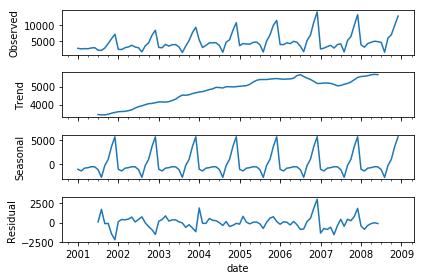

In [13]:
result = sm.tsa.seasonal_decompose(df)
result.plot();

# Model Training
Now that we have decomposed the Time Series, it will provide valuable insight into the most likely appropriate parameters to use with time series forecasting models.
Let's compare the performance of two of the most typical approaches: 1) ETS (AKA Holt-Winters); and 2) ARIMA (and its seasonal variations, SARIMAX).

## Pre-processing
Adjust the dataframe to work with `statsmodels` implementations, as well as setting the appropriate index as data-time, set target feature as double datatype (required by `statsmodels`), and split training/validation dataset:

In [14]:
# Check index is set as datetime data type
assert type(df.index) == pd.core.indexes.datetimes.DatetimeIndex

In [15]:
df.sales = df.sales.astype('double')

In [16]:
# Split Train/Validation. Last 6 months as validation

df_train = df.loc[df.index[:-6]]
df_test = df.loc[df.index[-6:]]

## 1) ETS (Holt-Winters)

In [17]:
try:
    v = sm.version.version
except:
    v = sm.__version__
print(f'Statsmodels version has to be >= 0.10 | Current version is {v}')

# ! pip install statsmodels --upgrade

# Requires to restart kernel after installation

Statsmodels version has to be >= 0.10 | Current version is 0.10.0


In [18]:
# Necessary to use latest version of statsmodels (>= 0.10), otherwise throws error. 
from statsmodels.tsa.holtwinters import ExponentialSmoothing as ETS

model = ETS(df_train, trend=None, damped=False, seasonal_periods=12, seasonal='mul')

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [19]:
forecast = model.fit()

In [20]:
yhat = forecast.forecast(6)

2008-07-01     4074.576914
2008-08-01     2153.467925
2008-09-01     5172.220501
2008-10-01     6798.234148
2008-11-01    10175.086213
2008-12-01    12746.642866
Freq: MS, dtype: float64


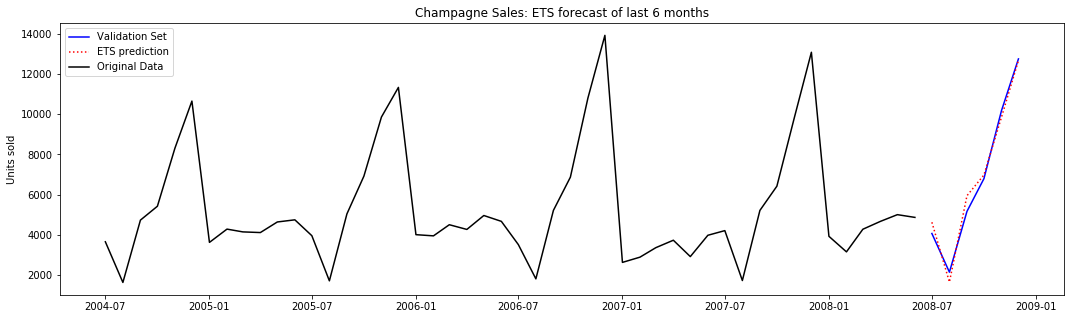

In [21]:
plt.figure(figsize=(18,5))
plt.plot(yhat, ls='-', c='b', label='Validation Set')
plt.plot(df_test, ls=':', c='r', label='ETS prediction')
plt.plot(df_train[-48:], ls='-', c='k', label='Original Data')
plt.title('Champagne Sales: ETS forecast of last 6 months')
plt.legend()
plt.ylabel('Units sold');
print(yhat)

In [30]:
score_ETS = forecast.aic
print(f'ETS model AIC: {score_ETS:,.2f}')

ETS model AIC: 1,164.26


In [22]:
forecast.summary()

Dep. Variable:,endog,No. Observations:,90
Model:,ExponentialSmoothing,SSE,27368860.251
Optimized:,True,AIC,1164.260
Trend:,None,BIC,1199.257
Seasonal:,Multiplicative,AICC,1171.712
Seasonal Periods:,12,Date:,"Thu, 11 Jul 2019"
Box-Cox:,False,Time:,09:39:02
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4558209,alpha,True
smoothing_seasonal,0.000000,gamma,True


## 3) Prophet (Facebook) - TO BE SKIPPED until fix Time Series decompose plot
Some extra steps are required to get this amazing package to work. Follow the installation instructions on the [Official FBProphetDocumentation](https://facebook.github.io/prophet/docs/installation.html), based on the appropriate OS/System.

Let's install via Conda:

In [ ]:
# ! pip install pystan

In [ ]:
# ! pip install fbprophet

This package requires the dataframe to be structured in a very particular manner:
+ Date component named as "ds"
+ Feature of interest named as "y"

In [35]:
from fbprophet import Prophet
model = Prophet()
model.fit(df_train)

ValueError: Dataframe must have columns 'ds' and 'y' with the dates and values respectively.